In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io
import utils_xy
from torchvision import transforms, utils
import numpy as np
from PIL import Image
from random import randint
import time

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print (device)

cuda


### I. Load the datasets

In [3]:
img_dir = '/home/xiaoyu/BMMC/BMMCdata'
mask_dir = '/home/xiaoyu/BMMC/BMMCmasks'

img_list = sorted(os.listdir(img_dir))
mask_list = sorted(os.listdir(mask_dir))

print("Training images numbers: "+str(len(img_list)))
print("Training mask Images numbers:"+str(len(mask_list)))

Training images numbers: 43
Training mask Images numbers:43


### Image and mask size observation
uint8	Unsigned integer (0 to 255)  
uint16	Unsigned integer (0 to 65535)

In [4]:
# Pick a random example
index = randint(0,42)
image_str = img_list[index]
mask_str = mask_list[index]

image_arr = io.imread(os.path.join(img_dir, image_str))
mask_arr = io.imread(os.path.join(mask_dir, mask_str))
print('Image array data type: ', image_arr.dtype)
print('\nMask array data type: ', mask_arr.dtype)

# convert the image data range from [0, 65535] to range [0,255]
image_arr = image_arr.astype(np.uint8)
print('\nImage array data type: ',image_arr.dtype)

# make 2 tensors from the numpy array for image and mask respectively
image_tensor = torch.from_numpy(image_arr)
mask_tensor = torch.from_numpy(mask_arr)

# observe the data size of the image and mask
print('\nImage data size: ', image_tensor.size())
print('\nMask data size:', mask_tensor.size())

Image array data type:  uint16

Mask array data type:  uint8

Image array data type:  uint8

Image data size:  torch.Size([1024, 1024, 3])

Mask data size: torch.Size([1024, 1024])


### Define a funciton for the visualization

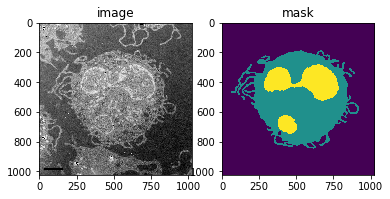

In [5]:
def show_mask(image, mask):
    """
    Show image and mask
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The training image semantic segmentation
    """    
    plt.subplot(1,2,1)
    plt.title('image')
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('mask')
    plt.imshow(mask)
    plt.show()
    
# test the function
show_mask(image_arr, mask_arr )

#### The input image is size 1024x1024x3, and the mask size is 1024x1024
### Find the unique color in mask
The unique color in mask is 85, 170, 255, so we can consider there are 3 classes in mask, for all 85 values, we consider it to be class 0, value 170 as class 1 and value 255 as class 2

In [6]:
colors = torch.tensor([])
for i in range(len(img_list)):
    img_arr = io.imread(os.path.join(img_dir, img_list[i]))
    img_tensor = torch.from_numpy(np.uint8(img_arr))
    img_tensor = img_tensor.permute(2,0,1)
    
    mask_str = mask_list[i]
    mask_arr = io.imread(os.path.join(mask_dir, mask_str))
    mask_tensor = torch.from_numpy(mask_arr)
    unique_color = torch.unique(mask_tensor).type(torch.FloatTensor)
    colors = torch.cat((colors,unique_color))
colors = torch.unique(colors)
print(colors)

tensor([ 85., 170., 255.])


### Test the mapping

In [7]:
mapp = {1:0,
        2:1,
        3:2}
b = torch.Tensor([1,2,1,3])
for k in mapp:
    b[b == k] = mapp[k]
print(b)

tensor([0., 1., 0., 2.])


### Define the training set class
In the TrainDataset, the image is a tensor whose size is C x H x W, the mask is a tensor whose size is H x W.
The transform attribute is only applied to image tensor. The preprocess of the mask image is done inside this TrainDataset, which means the resize to 128 x 128

In [8]:
class TrainDataset(Dataset):
    """Training dataset with mask image mapping to classes"""
    def __init__(self, img_dir, mask_dir, transform=None):
        """
        Args:
            train_dir (string): Directory with training images
            transform (callable): Optional transform to be applied on a sample
            semantic_dir (string): Directory with semantic segmentation training image
        """
        self.img_dir = img_dir
        self.transform = transform
        self.mask_dir = mask_dir
        # mapping the mask value to class value
        self.mapping = {
            85: 0.,
            170: 1.,
            255: 2.
        }
        
    def mask_to_class(self, mask):
        for k in self.mapping:
            mask[mask==k] = self.mapping[k]
        return mask
        
    def __len__(self):
        img_list = os.listdir(self.img_dir)
        return len(img_list)
    
    def __getitem__(self, idx):
        img_list = sorted(os.listdir(img_dir))
        mask_list = sorted(os.listdir(mask_dir))
        
        img_str = img_list[idx]
        img_arr = io.imread(os.path.join(img_dir, img_str))
        img_tensor = torch.from_numpy(np.uint8(img_arr))
        img_tensor = img_tensor.permute(2,0,1)
        
        mask_str = mask_list[idx]
        mask_arr = io.imread(os.path.join(mask_dir, mask_str))
        mask_tensor = torch.from_numpy(mask_arr)
        
        # after the compose, the mask value range is [0,1], the data type is torch.float32
#         compose = transforms.Compose([transforms.ToPILImage(),
#                                       transforms.Resize((388,388),interpolation=Image.NEAREST), 
#                                       transforms.ToTensor()])
        
#         mask_tensor = torch.unsqueeze(mask_tensor, dim = 0)
#         mask_tensor = compose(mask_tensor)
#         mask_tensor = mask_tensor.squeeze()
        
        mask_tensor = self.mask_to_class(mask_tensor)
      
        sample = {'image':img_tensor, 'mask':mask_tensor}
        
        if self.transform:
            image = self.transform(img_tensor)
            sample = {'image':image, 'mask':mask_tensor}
        return sample

* `transforms.ToPILImage()` preserving the value range. 
* `transforms.ToTensor()` Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].

### Test the traindataset class without transforms and find out the color mapping in the mask
We can see here 
* image data is in the range [0,255], the data type is uint8.
* mask data is in the range [0,1.0], data type is float32  


In [9]:
train_data = TrainDataset(img_dir=img_dir, mask_dir = mask_dir)
print('Total image number: {}'.format(len(train_data)))
colors = torch.tensor([])

for i in range(len(train_data)):
    sample = train_data[i]
    image = sample['image']
    mask = sample['mask']
    unique_color = torch.unique(mask).float()
    colors = torch.cat((colors,unique_color))
colors = torch.unique(colors)
print(colors)

Total image number: 43
tensor([0., 1., 2.])


### DATA transformation
* `torchvision.transforms.ToPILImage()` Convert the image torch.*Tensor of shape C x H x W to a PIL Image while preserving the value range, which is [0,255]
* `torchvision.transforms.Resize(size, interpolation=2)` Resize the input PIL Image to the given size 128 x 128
* `torchvision.transforms.ToTensor` Converts the PIL Image in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
* `torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))` Normalize the image tensor to Tensors of normalized range [-1, 1].

In [10]:
compose = transforms.Compose([transforms.ToPILImage(), 
                              transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

tensor([[[114, 109, 115,  ..., 167, 167, 166],
         [106, 118, 116,  ..., 184, 163, 168],
         [119, 123, 125,  ..., 186, 177, 171],
         ...,
         [197, 203, 186,  ..., 119, 117, 113],
         [187, 177, 163,  ..., 118, 112, 108],
         [194, 183, 184,  ...,  85, 109, 103]],

        [[114, 109, 115,  ..., 167, 167, 166],
         [106, 118, 116,  ..., 184, 163, 168],
         [119, 123, 125,  ..., 186, 177, 171],
         ...,
         [197, 203, 186,  ..., 119, 117, 113],
         [187, 177, 163,  ..., 118, 112, 108],
         [194, 183, 184,  ...,  85, 109, 103]],

        [[114, 109, 115,  ..., 167, 167, 166],
         [106, 118, 116,  ..., 184, 163, 168],
         [119, 123, 125,  ..., 186, 177, 171],
         ...,
         [197, 203, 186,  ..., 119, 117, 113],
         [187, 177, 163,  ..., 118, 112, 108],
         [194, 183, 184,  ...,  85, 109, 103]]], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  

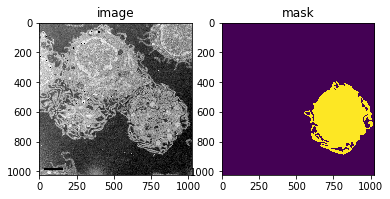

The rescaled image:
tensor([[[-0.1059, -0.1451, -0.0980,  ...,  0.3098,  0.3098,  0.3020],
         [-0.1686, -0.0745, -0.0902,  ...,  0.4431,  0.2784,  0.3176],
         [-0.0667, -0.0353, -0.0196,  ...,  0.4588,  0.3882,  0.3412],
         ...,
         [ 0.5451,  0.5922,  0.4588,  ..., -0.0667, -0.0824, -0.1137],
         [ 0.4667,  0.3882,  0.2784,  ..., -0.0745, -0.1216, -0.1529],
         [ 0.5216,  0.4353,  0.4431,  ..., -0.3333, -0.1451, -0.1922]],

        [[-0.1059, -0.1451, -0.0980,  ...,  0.3098,  0.3098,  0.3020],
         [-0.1686, -0.0745, -0.0902,  ...,  0.4431,  0.2784,  0.3176],
         [-0.0667, -0.0353, -0.0196,  ...,  0.4588,  0.3882,  0.3412],
         ...,
         [ 0.5451,  0.5922,  0.4588,  ..., -0.0667, -0.0824, -0.1137],
         [ 0.4667,  0.3882,  0.2784,  ..., -0.0745, -0.1216, -0.1529],
         [ 0.5216,  0.4353,  0.4431,  ..., -0.3333, -0.1451, -0.1922]],

        [[-0.1059, -0.1451, -0.0980,  ...,  0.3098,  0.3098,  0.3020],
         [-0.1686, -0.074

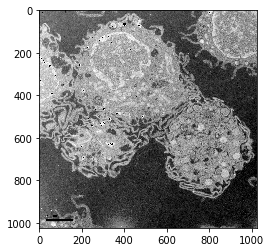

The mask:


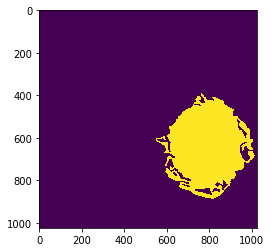

In [11]:
## Test of the transformation
fig = plt.figure()
# Pick a sample
idx = randint(0,42)
sample = train_data[idx]
img = sample['image']
mask = sample['mask']
print(img)
print(mask)

# original image visualization
print("The original image:")
show_mask(img.permute(1,2,0), mask)

# rescaled image visualization
print("The rescaled image:")
rescaled_image = compose(img)
print(rescaled_image)
rescaled_image = rescaled_image / 2 + 0.5     # unnormalize
print(rescaled_image.size())

print(type(rescaled_image))
plt.imshow(rescaled_image.permute(1,2,0))
plt.pause(0.5)

print('The mask:')
## All images in torchvision have to be represented as 3-dimensional tensors of the form [Channel, Height, Width]. 
## the sample['mask'] tensor is a 2d tensor (height x width), so it's needed to unsqueeze it first

plt.imshow(sample['mask'])

### Define the transformed dataset

In [12]:
transformed_dataset = TrainDataset(img_dir=img_dir, mask_dir = mask_dir, transform = compose)

### Test the transformed dataset, visualization of the dataset
In the transformed dataset, 
* Image data type is `torch.float32`, data range is :[-1,1]
* Mask data type is `torch.float32`, data value is (0.3333, 0.6667, 1.000)

torch.Size([3, 1024, 1024])
torch.float32
tensor(1.)
tensor(-1.)
torch.uint8
torch.Size([1024, 1024])
tensor(2, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>
The image is:


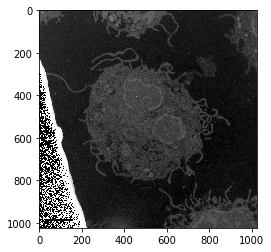

torch.Size([1024, 1024])
<class 'torch.Tensor'>
The mask is:


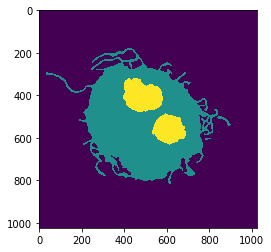

In [13]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    img = sample['image']
    mask = sample['mask']
    
    print(img.size())
    print(img.dtype)
    print(torch.max(img))
    print(torch.min(img))
    
    print(mask.dtype)
    print(mask.size())
    print(torch.max(mask))
    print(torch.min(mask))
    print(type(img))
    print('The image is:')
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(img.permute(1,2,0))
    plt.pause(0.5)
    
    print(mask.size())
    print(type(mask))
    print('The mask is:')
    plt.imshow(mask)
    plt.pause(0.5)
    if i == 0:  
        break

### Use the dataloader in Pytorch to form the train dataset
Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

In [14]:
dataloader = DataLoader(transformed_dataset, batch_size = 1, shuffle = True, num_workers = 4)

In [15]:
print(len(dataloader))

43


In [16]:
for i_batch, sample_batched in enumerate(dataloader):
    print(sample_batched['image'].size())
    print(sample_batched['mask'].size())
    if i_batch ==0:
        break

torch.Size([1, 3, 1024, 1024])
torch.Size([1, 1024, 1024])


### Define the network

In [17]:
class double_conv(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(double_conv, self).__init__()
        
        self.doubleconv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding =1), #same padding
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, kernel_size = 3,padding =1), #same padding
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.doubleconv(x)
        return x

#### The down class represent the maxpool layer and the first block, which means the down flow in unet

In [18]:
class down(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(down, self).__init__()
        self.downconv = nn.Sequential(
            nn.MaxPool2d(2, stride = 2),
            double_conv(in_channel, out_channel)
        )
    def forward(self, x):
        x = self.downconv(x)
        return x        

### The up class represent the block in the expansive path

In [19]:
class up(nn.Module):
    def __init__(self,in_channel, out_channel):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channel, out_channel, kernel_size = 2, stride = 2)
        self.conv = double_conv(in_channel, out_channel)
    def forward(self, x1, x2):
        # after the convtranspose2d, the output W,H doubled.
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        # crop x2 
        x2 = x2[:,:,diffY//2:diffY//2+x1.size()[2] , diffX//2:diffY//2+x1.size()[3]] 
        x = torch.cat([x2,x1], dim = 1)
        x = self.conv(x)
        return x

#### The final conv layer

In [20]:
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

### Pack all layers together

In [21]:
class UNet(nn.Module):
    """
    Args:
        input channel(int)
        output channel(int)
    """
    def __init__(self):
        super(UNet, self).__init__()
        self.conv_in = double_conv(3,64)

        self.down1 = down(64,128)
        self.down2 = down(128,256)
        self.down3 = down(256,512)
        self.down4 = down(512,1024)
        
        self.up1 = up(1024,512)
        self.up2 = up(512,256)
        self.up3 = up(256,128)
        self.up4 = up(128,64)
        
        self.conv_out = outconv(64,3)
       

    def forward(self, x):
        x1 = self.conv_in(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.conv_out(x)
        x = F.log_softmax(x, dim =1)
        return x

### Unet parameters

In [22]:
# input channel is 3, output channel is 1
unet = UNet()
print(unet)
unet_params = list(unet.parameters())
print("The length of the unet parameter is: ")
print(len(unet_params))
print("The conv1's weight: ")
print(unet_params[0].size()) # conv1's weight  0.4.
print("The weight's dtype: ")
print(unet_params[0].dtype)

UNet(
  (conv_in): double_conv(
    (doubleconv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): down(
    (downconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (doubleconv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

#### Test the Unet

In [23]:
bs=1
x=torch.rand(bs,3,1024,1024)
y = unet(x)
print(y.size())

torch.Size([1, 3, 1024, 1024])


### Make sure the current device 

In [24]:
current_device = torch.cuda.current_device()
torch.cuda.device(current_device)

In [25]:
torch.cuda.device_count()

1

In [26]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [27]:
unet = unet.to(device)

In [28]:
print(unet_params[0].dtype)

torch.float32


### Define the loss function and learning rate

In [29]:
criterion = nn.NLLLoss()

In [30]:
def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs    

#### Inputs size: bs x 3 x 572 x 572 tensor, which is in range [-1,1], data type is float32
#### Labels size: bs x 572 x 572 tensor, the values is 0.3333, 0.6667, 0.1, data type is float32

In [31]:
start=time.time()
for epoch in range(1,20):
   
        
    optimizer = optim.Adam(unet.parameters() ,lr=0.001)

    # define the running loss
    running_loss = 0
    running_error = 0
    num_batches=0
      
    for i_batch, sample_batched in enumerate(dataloader):
        
        optimizer.zero_grad()
        
        #get the inputs
        inputs, labels = sample_batched['image'], sample_batched['mask']
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs.requires_grad_()
        
        #forward + backward +optimize
        scores = unet(inputs)
      

        # Define the loss
        loss = criterion(scores, labels.long()) 
        loss.backward()
        optimizer.step()
        
        # compute and accumulate stats
        running_loss += loss.detach().item()
       
        num_batches+=1 
    
    # AVERAGE STATS THEN DISPLAY    
    total_loss = running_loss/num_batches
   
    elapsed = (time.time()-start)/60
        
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t loss=', total_loss )

       
print('Finish Training')

epoch= 1 	 time= 0.46637961864471433 min 	 loss= 0.7209592115047366
epoch= 2 	 time= 0.9377669175465901 min 	 loss= 0.5076466805713121
epoch= 3 	 time= 1.4131951292355855 min 	 loss= 0.4623454053734624
epoch= 4 	 time= 1.8908079465230305 min 	 loss= 0.4141747715861298
epoch= 5 	 time= 2.36847984790802 min 	 loss= 0.4089171231486077
epoch= 6 	 time= 2.8494702219963073 min 	 loss= 0.40737432657286177
epoch= 7 	 time= 3.3300500830014546 min 	 loss= 0.3843508882578029
epoch= 8 	 time= 3.810955850283305 min 	 loss= 0.37698637850062794
epoch= 9 	 time= 4.291796708106995 min 	 loss= 0.3533540641845659
epoch= 10 	 time= 4.774324059486389 min 	 loss= 0.3631394554016202
epoch= 11 	 time= 5.255969611803691 min 	 loss= 0.3527676116588504
epoch= 12 	 time= 5.736846669514974 min 	 loss= 0.3660031227871429
epoch= 13 	 time= 6.218869952360789 min 	 loss= 0.3478975216316622
epoch= 14 	 time= 6.701417815685272 min 	 loss= 0.3489701044420863
epoch= 15 	 time= 7.183563613891602 min 	 loss= 0.3346489927796

#### Choose image at random from the test set and see how good/bad are the predictions

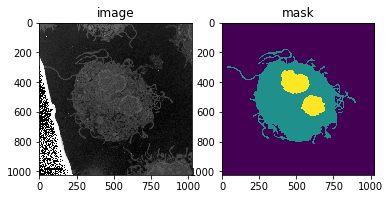

In [32]:
sample=train_data[0]
img = sample['image']
mask = sample['mask']

show_mask(img.permute(1,2,0), mask)

compose = transforms.Compose([transforms.ToPILImage(),
                              transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

img = compose(img)

img = img.unsqueeze(dim = 0)
img = img.to(device)

# feed it to network
scores =  unet(img)

scores = scores.detach().cpu().squeeze()

a = torch.tensor(0.)

idx = torch.Tensor([[]])

# for i in range(scores.size(1)):
#     for j in range(scores.size(2)):
#         pixel = scores[:,i,j]
#         for k in range(3):
#             if(pixel[k]>a):
#                 a = pixel[k]
#                 idx = k
        


In [33]:
out_put = torch.Tensor([])
mapp = {
        0 : torch.Tensor([255, 255, 255]),
        1 : torch.Tensor([255, 0, 0]),
        2 : torch.Tensor([0, 255, 0])
       }
output = torch.Tensor([0,1,0,2])

for i in output:
    print(mapp[np.uint(i.numpy())])
    out_put = torch.cat((out_put,mapp[np.uint(i.numpy())].unsqueeze(dim = 0)))
print(out_put)

tensor([255., 255., 255.])
tensor([255.,   0.,   0.])
tensor([255., 255., 255.])
tensor([  0., 255.,   0.])
tensor([[255., 255., 255.],
        [255.,   0.,   0.],
        [255., 255., 255.],
        [  0., 255.,   0.]])
